# Pseudo-Hamiltonian neural networks

This notebook provides examples of how you can use the package `phlearn` to generate data and train pseudo-Hamiltonian neural networks to model pseudo-Hamiltonian systems. The examples included here are the damped and forced mass-spring system and the system of tanks and pipes used in the paper ["Pseudo-Hamiltonian Neural Networks with State-Dependent
External Forces"](https://arxiv.org/abs/2206.02660).

In [2]:
import numpy as np
import torch
import networkx as nx

from phlearn.phsystems import MassSpringDamperSystem, TankSystem, init_tanksystem
from phlearn.phsystems import init_tanksystem_leaky, init_msdsystem, initial_condition_radial
from phlearn.phnns import PseudoHamiltonianNN, DynamicSystemNN, load_dynamic_system_model
from phlearn.phnns import R_estimator, BaselineNN, BaselineSplitNN, HamiltonianNN, ExternalForcesNN
from phlearn.phnns import npoints_to_ntrajectories_tsample, train, generate_dataset

import matplotlib.pyplot as plt

import simtools

ALLOWED_SYSTEMS = ["spring", "tank"]

colors = [(0,0.4,1),(1,0.7,0.3),(0.2,0.7,0.2),(0.8,0,0.2),(0.5,0.3,.9)]

ttype = torch.float32
torch.set_default_dtype(ttype)

### Initializing the data, neural network models and training parameters

In [3]:
system = 'spring'  # 'tank', 'msd' (Choose to train a tank or a forced and damped mass-spring system)

In [4]:
# Model params
baseline = 0 # 0: PHNN; 1: One-network baseline model; 2: Two-network baseline model
true_derivatives = False
if true_derivatives: # If true_derivatives is True, use the true derivative values for training
    integrator = False
else: # If true_derivatives is False, use an integration scheme
    integrator = 'midpoint' # 'euler', 'midpoint', 'rk4', or 'srk4'
F_timedependent = True 
F_statedependent =  False 


# Hyper params


# Simulation params
seed = 1
verbose = True
noise_std = 0. # Standard deviation or Gaussian white noise on the data
sampling_time = 1/100
t_max = 1. if system=='tank' else 10.

ntrajectories_train, t_sample = npoints_to_ntrajectories_tsample(ntrainingpoints, t_max, sampling_time)

### Setting up the system

In [5]:

f0 = 1
omega = 3
def F(x, t):
    return (f0*np.sin(omega*t)).reshape(x[..., 1:].shape)*np.array([0, 1])
pH_system = MassSpringDamperSystem(mass=1.0, spring_constant=1.0, damping=0.3,
                                    external_forces=F, init_sampler=initial_condition_radial(1, 4.5))

damped_states = [False, True]

pH_system.seed(seed)
nstates = pH_system.nstates

/Users/bentapley/Library/CloudStorage/OneDrive-SharedLibraries-SINTEF/port-hamiltonian-neural-networks/phlearn/venv/lib/python3.9/site-packages/phlearn-1.0.0-py3.9.egg/phlearn/phsystems/tank_system.py:91: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  B = np.array(nx.linalg.graphmatrix.incidence_matrix(


### Setting up the model

We can choose to either set up a PHNN model or use a baseline model. There are two alternatives for the baseline model: the first models the right hand side of the dynamic system by one neural network taking both $x$ and $t$ as input; the second models the right hand side by two separate networks, one taking $x$ and one taking $t$.

In [6]:
if baseline == 1:
    baseline_nn = BaselineNN(nstates, hidden_dim, timedependent=F_timedependent, statedependent=True)
    model = DynamicSystemNN(nstates, baseline_nn)
elif baseline == 2:
    external_forces_filter_t = np.zeros(nstates)
    external_forces_filter_t[-1] = 1 # Assuming that there is an external force only on the last state variable
    baseline_nn = BaselineSplitNN(
        nstates, hidden_dim, noutputs_x=nstates,
        noutputs_t=1, external_forces_filter_x=None,
        external_forces_filter_t=external_forces_filter_t,
        ttype=ttype)
    model = DynamicSystemNN(nstates, baseline_nn)

else:
    hamiltonian_nn = HamiltonianNN(nstates, hidden_dim)
    external_forces_filter = np.zeros(nstates)
    external_forces_filter[-1] = 1 # Assuming that there is an external force only on the last state variable
    ext_forces_nn = ExternalForcesNN(nstates, 1, hidden_dim=hidden_dim,
                                 timedependent=F_timedependent,
                                 statedependent=F_statedependent,
                                 external_forces_filter=external_forces_filter)

    r_est = R_estimator(damped_states)

    model = PseudoHamiltonianNN(nstates,
                              pH_system.structure_matrix,
                              hamiltonian_est=hamiltonian_nn,
                              dissipation_est=r_est,
                              external_forces_est=ext_forces_nn)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

### Generating training data

In [7]:
traindata = generate_dataset(
    pH_system, ntrajectories_train, t_sample, true_derivatives,
    nsamples=ntrainingpoints, noise_std=noise_std)
valdata = generate_dataset(
    pH_system, ntrajectories_val, t_sample, true_derivatives, noise_std=noise_std)

### Training the model

In [8]:
model, vloss = train(model, integrator, traindata, optimizer,
                     valdata=valdata, epochs=epochs,
                     batch_size=batch_size, shuffle=shuffle,
                     l1_param_forces=l1_param_forces,
                     l1_param_dissipation=l1_param_dissipation,
                     loss_fn=torch.nn.MSELoss(), verbose=verbose,
                     early_stopping_patience=early_stopping_patience,
                     early_stopping_delta=early_stopping_delta, return_best=True)

/Users/bentapley/Library/CloudStorage/OneDrive-SharedLibraries-SINTEF/port-hamiltonian-neural-networks/phlearn/venv/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



Epoch 1
Training loss: 4.72e+01
Epoch training time: 0.71seconds

Epoch 2
Training loss: 2.58e+00
Epoch training time: 0.69seconds

Epoch 3
Training loss: 7.67e-01
Epoch training time: 0.68seconds

Epoch 4
Training loss: 5.78e-01
Epoch training time: 0.67seconds

Epoch 5
Training loss: 4.8e-01
Epoch training time: 0.68seconds

Epoch 6
Training loss: 3.95e-01
Epoch training time: 0.68seconds

Epoch 7
Training loss: 3.23e-01
Epoch training time: 0.69seconds

Epoch 8
Training loss: 2.62e-01
Epoch training time: 0.68seconds

Epoch 9
Training loss: 2.17e-01
Epoch training time: 0.68seconds

Epoch 10
Training loss: 1.88e-01
Epoch training time: 0.68seconds

Epoch 11
Training loss: 1.63e-01
Epoch training time: 0.68seconds

Epoch 12
Training loss: 1.37e-01
Epoch training time: 0.68seconds

Epoch 13
Training loss: 1.19e-01
Epoch training time: 0.68seconds

Epoch 14
Training loss: 1.04e-01
Epoch training time: 0.67seconds

Epoch 15
Training loss: 9.26e-02
Epoch training time: 0.67seconds

Epoc

### Integrating the learned system and comparing to exact trajectories

In [9]:
t_max = 1 if system == 'tank' else 10
dt = 0.01
seed = 7

In [10]:
pH_system.seed(seed)
t_sample = np.arange(0, t_max, dt)
nsamples = t_sample.shape[0]

x_exact, dxdt, _, _ = pH_system.sample_trajectory(t_sample)
x0 = x_exact[0, :]
x_phnn, _ = model.simulate_trajectory(integrator=False, t_sample=t_sample, x0=x0)

#### Calculating errors:

In [11]:
if isinstance(model, PseudoHamiltonianNN):
    if (not model.external_forces_provided):
        F_phnn = model.external_forces(torch.tensor(x_phnn, dtype=ttype),
                                     torch.tensor(t_sample.reshape(nsamples, 1), dtype=ttype)).detach().numpy()
        F_phnn_mean = F_phnn.mean(axis=0)
        F_phnn -= F_phnn_mean
        F_exact = pH_system.external_forces(x_exact, t_sample)
        print('External force MSE:', ((F_phnn - F_exact)**2).mean())
        print('External force MAE:', np.abs(F_phnn - F_exact).mean())
    if (not model.dissipation_provided):
        print('R MSE:', ((model.R(x_exact).detach().numpy() - pH_system.R(x_exact))**2).mean())
        print('R MAE:', np.abs(model.R(x_exact).detach().numpy() - pH_system.R(x_exact)).mean())
    if (not model.hamiltonian_provided):
        if pH_system.H is not None:
            hamiltonian_exact = pH_system.H(x_exact)
            hamiltonian_phnn = model.hamiltonian(torch.tensor(x_phnn, dtype=ttype)).detach().numpy()
            hamiltonian_exact = pH_system.H(x_exact)
            hamiltonian_phnn = model.hamiltonian(torch.tensor(x_phnn, dtype=ttype)).detach().numpy()
            print('H MSE:', ((hamiltonian_exact - hamiltonian_phnn)**2).mean())
            print('H MAE:', np.abs(hamiltonian_exact - hamiltonian_phnn).mean())
        dH_exact = pH_system.dH(x_exact)
        dH_phnn = model.dH(torch.tensor(x_phnn, dtype=ttype)).detach().numpy()
        if system == 'tank':
            print('dH tanks MSE:', ((pH_system.tanklevels(dH_exact) - pH_system.tanklevels(dH_phnn))**2).mean())
            print('dH tanks MAE:', np.abs(pH_system.tanklevels(dH_exact) - pH_system.tanklevels(dH_phnn)).mean())
            print('dH pipes MSE:', ((pH_system.pipeflows(dH_exact) - pH_system.pipeflows(dH_phnn))**2).mean())
            print('dH pipes MAE:', np.abs(pH_system.pipeflows(dH_exact) - pH_system.pipeflows(dH_phnn)).mean())
        else:
            print('dH x1 MSE:', ((dH_exact[:, 0] - dH_phnn[:, 0])**2).mean())
            print('dH x1 MAE:', np.abs(dH_exact[:, 0] - dH_phnn[:, 0]).mean())
            print('dH x2 MSE:', ((dH_exact[:, 1] - dH_phnn[:, 1])**2).mean())
            print('dH x2 MAE:', np.abs(dH_exact[:, 1] - dH_phnn[:, 1]).mean())
elif isinstance(model.rhs_model, BaselineSplitNN):
    F_baseline = model.rhs_model.network_t(torch.tensor(x_phnn, dtype=ttype),
                                 torch.tensor(t_sample.reshape(nsamples, 1), dtype=ttype)).detach().numpy()
    F_baseline -= F_baseline.mean(axis=0)
    F_exact = pH_system.external_forces(x_exact, t_sample)
    print('External force MSE:', ((F_baseline - F_exact)**2).mean())
    print('External force MAE:', np.abs(F_baseline - F_exact).mean())

if system == 'tank':
    print('Tanks MSE:', ((pH_system.tanklevels(x_exact) - pH_system.tanklevels(x_phnn))**2).mean())
    print('Pipes MSE:', ((pH_system.pipeflows(x_exact) - pH_system.pipeflows(x_phnn))**2).mean())
    print('Tanks MAE:', np.abs(pH_system.tanklevels(x_exact) - pH_system.tanklevels(x_phnn)).mean())
    print('Pipes MAE:', np.abs(pH_system.pipeflows(x_exact) - pH_system.pipeflows(x_phnn)).mean())
else:
    print('x1 MSE:', ((x_exact[:, 0] - x_phnn[:, 0])**2).mean())
    print('x1 MAE:', np.abs(x_exact[:, 0] - x_phnn[:, 0]).mean())
    print('x2 MSE:', ((x_exact[:, 1] - x_phnn[:, 1])**2).mean())
    print('x2 MAE:', np.abs(x_exact[:, 1] - x_phnn[:, 1]).mean())

External force MSE: 0.17581540840501
External force MAE: 0.12413158691633094
R MSE: 6.338203967126648e-06
R MAE: 0.0006107568943206176
H MSE: 1248799.5220292562
H MAE: 1117.3634583566022
dH tanks MSE: 10.807613631272215
dH tanks MAE: 2.9799138951114243
dH pipes MSE: 25.62337492676716
dH pipes MAE: 3.949353264709842
Tanks MSE: 0.017328891377074728
Pipes MSE: 0.00571223653134774
Tanks MAE: 0.08919651813133381
Pipes MAE: 0.05684300062882126


#### Plotting

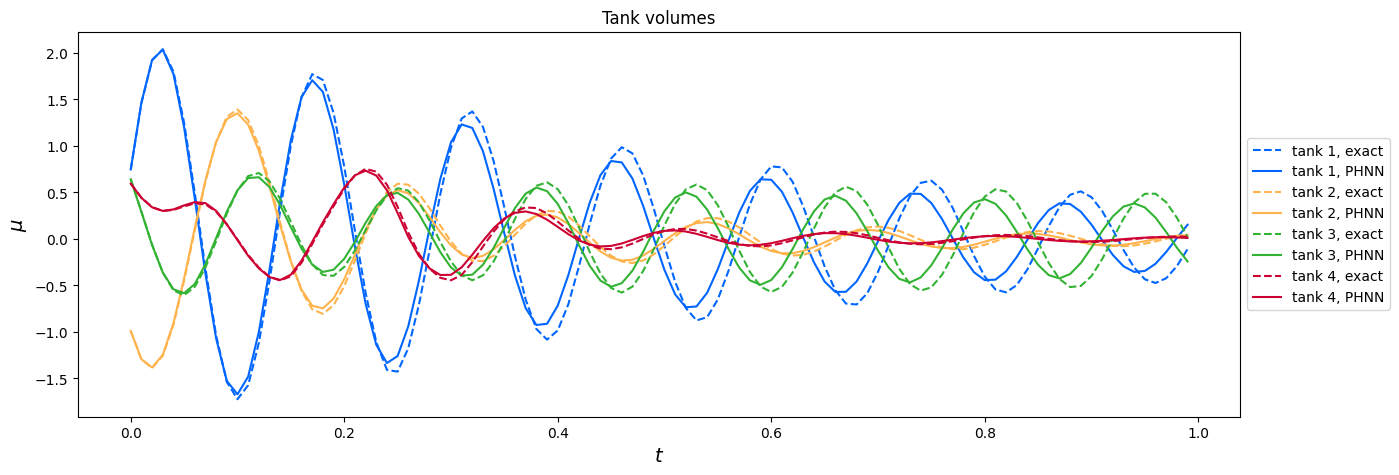

In [12]:
if system == 'tank':
    fig = plt.figure(figsize=(15,5))
    for i in range(0, pH_system.ntanks):
        plt.plot(t_sample, x_exact[:,i+pH_system.npipes], color=colors[i], linestyle='dashed', label=f'tank {i+1}, exact')
        plt.plot(t_sample, x_phnn[:,i+pH_system.npipes], color=colors[i], label=f'tank {i+1}, PHNN')
    plt.xlabel("$t$", fontsize=14)
    plt.ylabel("$\mu$", fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Tank volumes')
    plt.show()
elif system == 'msd':
    fig = plt.figure(figsize=(5,5))
    plt.plot(x_exact[:,0], x_exact[:,1], color='k', linestyle='dashed', label=f'Exact')
    plt.plot(x_phnn[:,0], x_phnn[:,1], color=colors[0], label=f'PHNN')
    plt.xlabel("$q$", fontsize=14)
    plt.ylabel("$p$", fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Phase plot')
    plt.show()
    fig = plt.figure(figsize=(15,5))
    plt.plot(t_sample, x_exact[:,0], color='k', linestyle='dashed', label=f'Exact')
    plt.plot(t_sample, x_phnn[:,0], color=colors[0], label=f'PHNN')
    plt.xlabel("$t$", fontsize=14)
    plt.ylabel("$q$", fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Position')
    plt.show()
    fig = plt.figure(figsize=(15,5))
    plt.plot(t_sample, x_exact[:,1], color='k', linestyle='dashed', label=f'Exact')
    plt.plot(t_sample, x_phnn[:,1], color=colors[0], label=f'PHNN')
    plt.xlabel("$t$", fontsize=14)
    plt.ylabel("$p$", fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Momentum')
    plt.show()

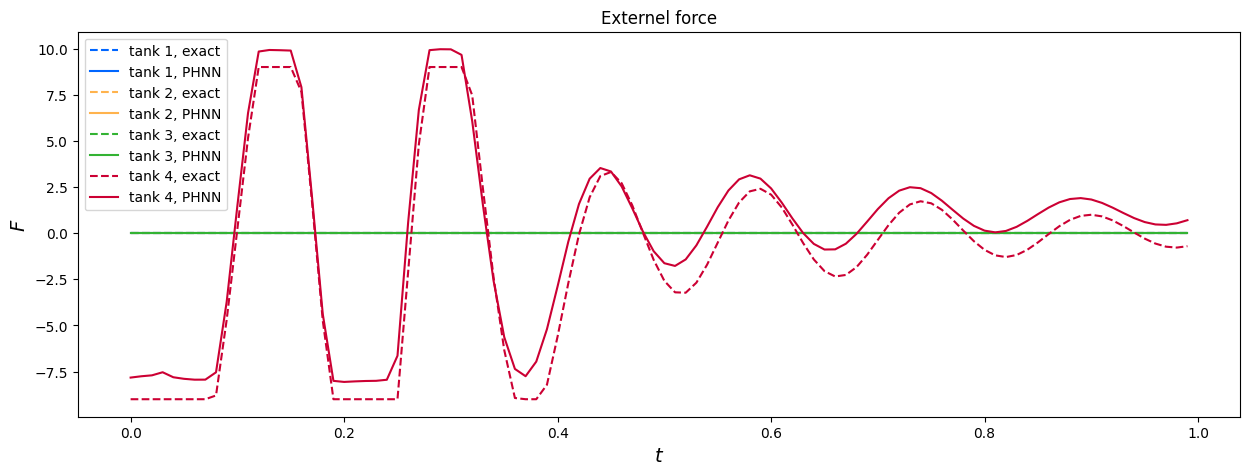

In [13]:
if isinstance(model, PseudoHamiltonianNN) or isinstance(model.rhs_model, BaselineSplitNN):
    if system == 'tank':
        fig = plt.figure(figsize=(15,5))
        for i in range(0, pH_system.ntanks):
            plt.plot(t_sample, F_exact[:,i+pH_system.npipes], color=colors[i], linestyle='dashed', label=f'tank {i+1}, exact')
            if isinstance(model, PseudoHamiltonianNN):
                try:
                    plt.plot(t_sample, F_phnn[:,i+pH_system.npipes], color=colors[i], label=f'tank {i+1}, PHNN')
                except:
                    plt.plot(t_sample, F_phnn[i+pH_system.npipes]*np.ones_like(t_sample), color=colors[i], label=f'tank {i+1}, PHNN')
            else:
                plt.plot(t_sample, F_baseline[:,i+pH_system.npipes], color=colors[i], label=f'tank {i+1}, Baseline')
        plt.xlabel("$t$", fontsize=14)
        plt.ylabel("$F$", fontsize=14)
        plt.title('Externel force')
        plt.legend()
        plt.show()
    elif system == 'msd':
        fig = plt.figure(figsize=(15,5))
        plt.plot(t_sample, F_exact[:,-1], color='k', linestyle='dashed', label=f'Exact')
        if isinstance(model, PseudoHamiltonianNN):
            try:
                plt.plot(t_sample, F_phnn[:,-1], color=colors[0], label=f'PHNN')
            except:
                plt.plot(t_sample, F_phnn[-1]*np.ones_like(t_sample), color=colors[0], label=f'PHNN')
        else:
            plt.plot(t_sample, F_baseline[:,-1], color=colors[0], label=f'Baseline')
        plt.xlabel("$t$", fontsize=14)
        plt.ylabel("$F$", fontsize=14)
        plt.title('Externel force')
        plt.legend()
        plt.show()

### Comparing to baseline model

Given that the above trained model is a PHNN model, we may wish to compare it to the appropriate baseline model.

In [14]:
if baseline != 0:
    raise SystemExit('Stop here. We have already trained a baseline model.')

In [15]:
if F_statedependent == True:
    baseline_nn = BaselineNN(nstates, hidden_dim, timedependent=F_timedependent, statedependent=True)
    baseline_model = DynamicSystemNN(nstates, baseline_nn)
else:
    external_forces_filter_t = np.zeros(nstates)
    external_forces_filter_t[-1] = 1
    baseline_nn = BaselineSplitNN(
        nstates, hidden_dim, noutputs_x=nstates,
        noutputs_t=1, external_forces_filter_x=None,
        external_forces_filter_t=external_forces_filter_t,
        ttype=ttype)
    baseline_model = DynamicSystemNN(nstates, baseline_nn)
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [16]:
baseline_model, _ = train(baseline_model, integrator, traindata, optimizer, valdata=valdata, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, l1_param_forces=l1_param_forces,
                  l1_param_dissipation=l1_param_dissipation,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, early_stopping_patience=early_stopping_patience,
                  early_stopping_delta=early_stopping_delta)


Epoch 1
Training loss: 3.58e+01
Epoch training time: 0.33seconds

Epoch 2
Training loss: 1.12e+00
Epoch training time: 0.33seconds

Epoch 3
Training loss: 8.21e-01
Epoch training time: 0.35seconds

Epoch 4
Training loss: 4.78e-01
Epoch training time: 0.33seconds

Epoch 5
Training loss: 2.43e-01
Epoch training time: 0.33seconds

Epoch 6
Training loss: 1.52e-01
Epoch training time: 0.33seconds

Epoch 7
Training loss: 9.72e-02
Epoch training time: 0.33seconds

Epoch 8
Training loss: 6.69e-02
Epoch training time: 0.32seconds

Epoch 9
Training loss: 5.33e-02
Epoch training time: 0.33seconds

Epoch 10
Training loss: 4.5e-02
Epoch training time: 0.32seconds

Epoch 11
Training loss: 3.93e-02
Epoch training time: 0.34seconds

Epoch 12
Training loss: 3.69e-02
Epoch training time: 0.32seconds

Epoch 13
Training loss: 3.32e-02
Epoch training time: 0.32seconds

Epoch 14
Training loss: 3.32e-02
Epoch training time: 0.32seconds

Epoch 15
Training loss: 2.98e-02
Epoch training time: 0.33seconds

Epoc

In [17]:
x_baseline, _ = baseline_model.simulate_trajectory(False, t_sample, x0=x0)

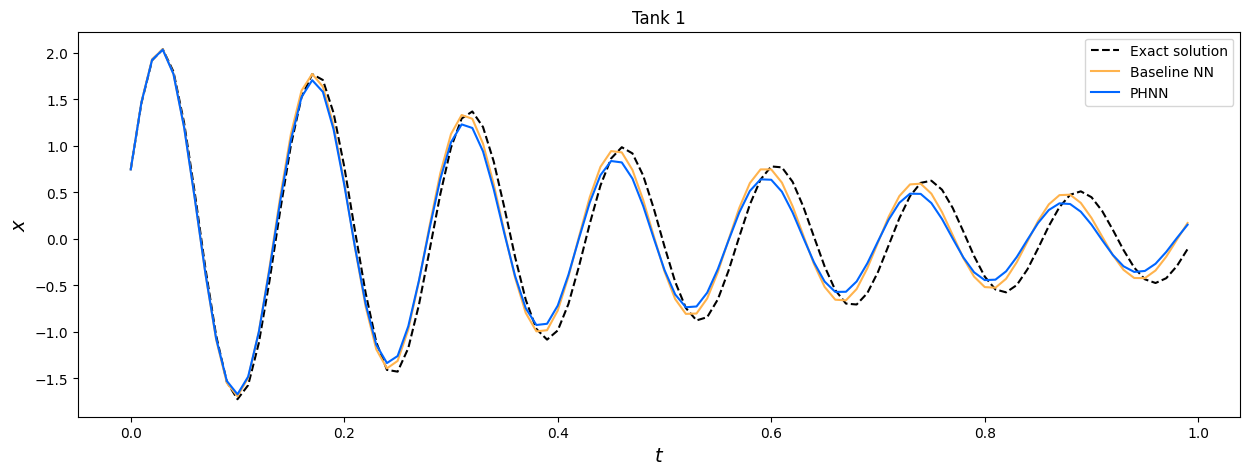

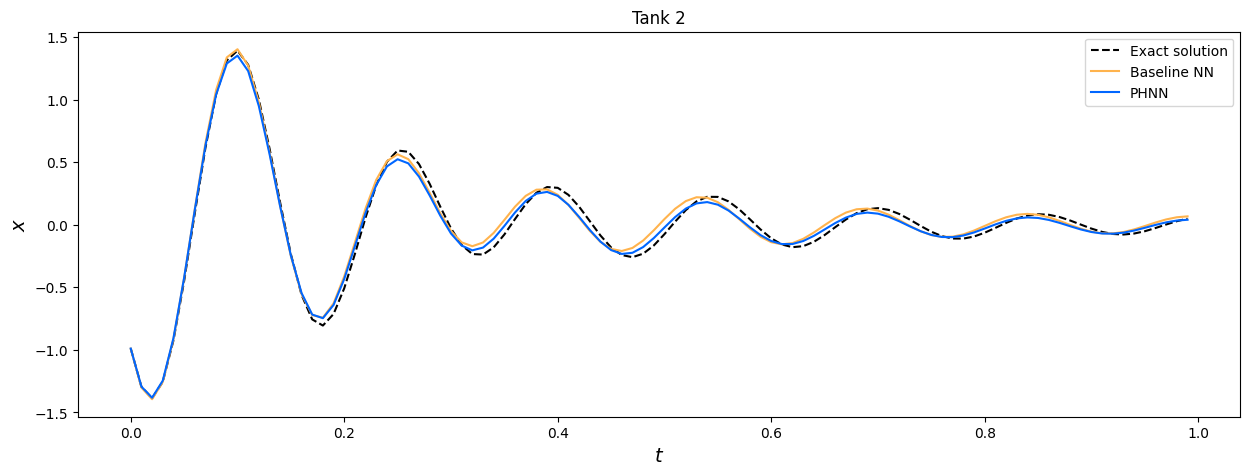

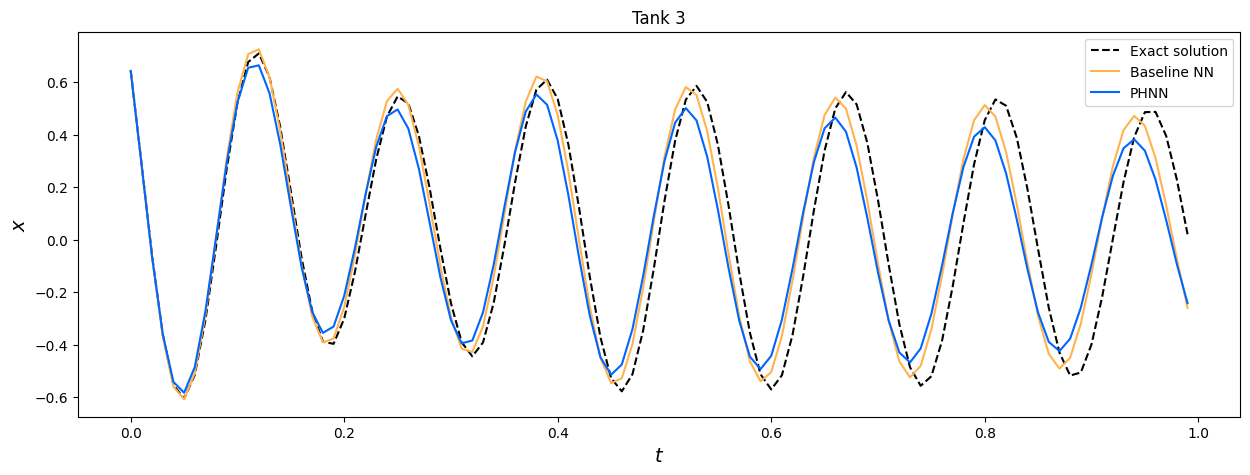

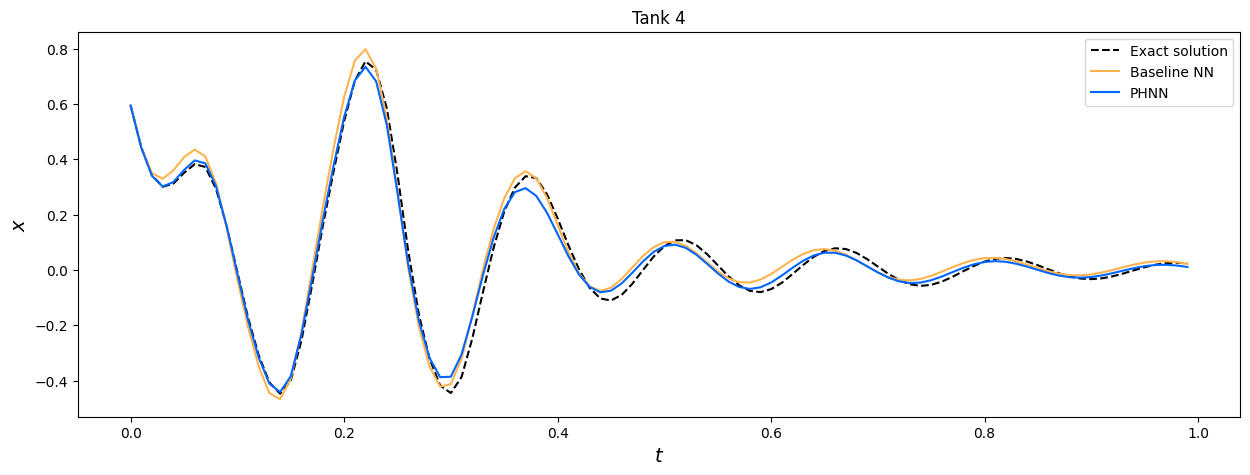

In [18]:
if system == 'tank':
    for i in range(0, pH_system.ntanks):
        fig = plt.figure(figsize=(15,5))
        plt.plot(t_sample, x_exact[:,i+pH_system.npipes], color='k', linestyle='dashed', label='Exact solution')  
        plt.plot(t_sample, x_baseline[:,i+pH_system.npipes], color=colors[1], label='Baseline NN')
        plt.plot(t_sample, x_phnn[:,i+pH_system.npipes], color=colors[0], label='PHNN')
        plt.xlabel("$t$", fontsize=14)
        plt.ylabel("$x$", fontsize=14)
        plt.title(f'Tank {i+1}')
        plt.legend()
        plt.show()
elif system == 'msd':
    fig = plt.figure(figsize=(5,5))
    plt.plot(x_exact[:,0], x_exact[:,1], color='k', linestyle='dashed', label='Exact')
    plt.plot(x_baseline[:,0], x_baseline[:,1], color=colors[1], label='Baseline')
    plt.plot(x_phnn[:,0], x_phnn[:,1], color=colors[0], label='PHNN')
    plt.xlabel("$t$", fontsize=14)
    plt.ylabel("$x$", fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Phase plot')
    plt.show()
    fig = plt.figure(figsize=(15,5))
    plt.plot(t_sample, x_exact[:,0], color='k', linestyle='dashed', label='Exact')
    plt.plot(t_sample, x_baseline[:,0], color=colors[1], label='Baseline')
    plt.plot(t_sample, x_phnn[:,0], color=colors[0], label='PHNN')
    plt.xlabel("$t$", fontsize=14)
    plt.ylabel("$x$", fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Position')
    plt.show()
    fig = plt.figure(figsize=(15,5))
    plt.plot(t_sample, x_exact[:,1], color='k', linestyle='dashed', label='Exact')
    plt.plot(t_sample, x_baseline[:,1], color=colors[1], label='Baseline')
    plt.plot(t_sample, x_phnn[:,1], color=colors[0], label='PHNN')
    plt.xlabel("$t$", fontsize=14)
    plt.ylabel("$x$", fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Momentum')
    plt.show()

In [19]:
if system == 'tank':
    print('PHNN Tanks MSE:', ((pH_system.tanklevels(x_exact) - pH_system.tanklevels(x_phnn))**2).mean())
    print('PHNN Pipes MSE:', ((pH_system.pipeflows(x_exact) - pH_system.pipeflows(x_phnn))**2).mean())
    print('Baseline Tanks MSE:', ((pH_system.tanklevels(x_exact) - pH_system.tanklevels(x_baseline))**2).mean())
    print('Baseline Pipes MSE:', ((pH_system.pipeflows(x_exact) - pH_system.pipeflows(x_baseline))**2).mean())
else:
    print('PHNN x1 MSE:', ((x_exact[:, 0] - x_phnn[:, 0])**2).mean())
    print('PHNN x2 MSE:', ((x_exact[:, 1] - x_phnn[:, 1])**2).mean())
    print('Baseline x1 MSE:', ((x_exact[:, 0] - x_baseline[:, 0])**2).mean())
    print('Baseline x2 MSE:', ((x_exact[:, 1] - x_baseline[:, 1])**2).mean())

PHNN Tanks MSE: 0.017328891377074728
PHNN Pipes MSE: 0.00571223653134774
Baseline Tanks MSE: 0.014890518250940015
Baseline Pipes MSE: 0.00222704268069587


In [20]:
if F_statedependent == False:
    F_baseline = baseline_model.rhs_model.network_t(torch.tensor(x_phnn, dtype=ttype),
                                 torch.tensor(t_sample.reshape(nsamples, 1), dtype=ttype)).detach().numpy()
    F_baseline -= F_baseline.mean(axis=0)
    if system == 'tank':
        fig = plt.figure(figsize=(15,5))
        for i in range(0, pH_system.ntanks):
            plt.plot(t_sample, F_exact[:,i+pH_system.npipes], color=colors[i], linestyle='dashed', label=f'tank {i+1}, exact')
            plt.plot(t_sample, F_baseline[:,i+pH_system.npipes], color=colors[i], linestyle='-.', label=f'tank {i+1}, Baseline')
            plt.plot(t_sample, F_phnn[:,i+pH_system.npipes], color=colors[i], label=f'tank {i+1}, PHNN')
        plt.xlabel("$t$", fontsize=14)
        plt.ylabel("$F$", fontsize=14)
        plt.title('Externel force')
        plt.legend()
        plt.show()
    elif system == 'msd':
        fig = plt.figure(figsize=(15,5))
        plt.plot(t_sample, F_exact[:,-1], color='k', linestyle='dashed', label=f'Exact')
        plt.plot(t_sample, F_baseline[:,-1], color=colors[1], linestyle='-', label=f'Baseline')
        plt.plot(t_sample, F_phnn[:,-1], color=colors[0], label=f'PHNN')
        plt.xlabel("$t$", fontsize=14)
        plt.ylabel("$F$", fontsize=14)
        plt.title('Externel force')
        plt.legend()
        plt.show()

### Removing the force(s)

We can remove the force(s) from our learned model and thus predict future system states without external forces.

In [21]:
if system == 'tank':
    pH_system_no_forces = TankSystem(system_graph=G_s, dissipation_pipes=R, J=J, A=A, external_forces=None, controller=None)
elif system == 'msd':
    pH_system_no_forces = MassSpringDamperSystem(mass=1.0, spring_constant=1.0, damping=0.3,
                                       external_forces=None, init_sampler=initial_condition_radial(1, 4.5))

Technically, if the external force is time dependent, we replace the learned external force with the mean of the external force. This is because the PHNN model is not able to separate constant terms between the internal system and the external forces.

In [22]:
if F_timedependent:
    def no_external_forces(x, t):
        return torch.tensor(F_phnn_mean)*torch.ones_like(x)
else:
    def no_external_forces(x, t):
        return torch.zeros_like(x)
    
phnn_model_no_forces = PseudoHamiltonianNN(nstates,
                              pH_system.structure_matrix,
                              hamiltonian_true=model.hamiltonian,
                              dissipation_true=model.R().detach(),
                              external_forces_true=no_external_forces)

In [ ]:
x_exact, _, _, _ = pH_system_no_forces.sample_trajectory(t_sample, x0=x0)
x_phnn, _ = phnn_model_no_forces.simulate_trajectory(integrator=False, t_sample=t_sample, x0=x0)

#### Calculating errors:

In [ ]:
if system == 'tank':
    print('Tanks MSE:', ((pH_system.tanklevels(x_exact) - pH_system_no_forces.tanklevels(x_phnn))**2).mean())
    print('Pipes MSE:', ((pH_system.pipeflows(x_exact) - pH_system_no_forces.pipeflows(x_phnn))**2).mean())
    print('Tanks MAE:', np.abs(pH_system.tanklevels(x_exact) - pH_system_no_forces.tanklevels(x_phnn)).mean())
    print('Pipes MAE:', np.abs(pH_system.pipeflows(x_exact) - pH_system_no_forces.pipeflows(x_phnn)).mean())
else:
    print('x1 MSE:', ((x_exact[:, 0] - x_phnn[:, 0])**2).mean())
    print('x1 MAE:', np.abs(x_exact[:, 0] - x_phnn[:, 0]).mean())
    print('x2 MSE:', ((x_exact[:, 1] - x_phnn[:, 1])**2).mean())
    print('x2 MAE:', np.abs(x_exact[:, 1] - x_phnn[:, 1]).mean())

#### Plotting:

In [ ]:
if system == 'tank':
    fig = plt.figure(figsize=(15,5))
    for i in range(0, pH_system.ntanks):
        plt.plot(t_sample, x_exact[:,i+pH_system.npipes], color=colors[i], linestyle='dashed', label=f'tank {i+1}, exact')
        plt.plot(t_sample, x_phnn[:,i+pH_system.npipes], color=colors[i], label=f'tank {i+1}, PHNN')
    plt.xlabel("$t$", fontsize=14)
    plt.ylabel("$\mu$", fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Tank volumes')
    plt.show()
elif system == 'msd':
    fig = plt.figure(figsize=(5,5))
    plt.plot(x_exact[:,0], x_exact[:,1], color='k', linestyle='dashed', label=f'Exact')
    plt.plot(x_phnn[:,0], x_phnn[:,1], color=colors[0], label=f'PHNN')
    plt.xlabel("$q$", fontsize=14)
    plt.ylabel("$p$", fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Phase plot')
    plt.show()
    fig = plt.figure(figsize=(15,5))
    plt.plot(t_sample, x_exact[:,0], color='k', linestyle='dashed', label=f'Exact')
    plt.plot(t_sample, x_phnn[:,0], color=colors[0], label=f'PHNN')
    plt.xlabel("$t$", fontsize=14)
    plt.ylabel("$q$", fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Position')
    plt.show()
    fig = plt.figure(figsize=(15,5))
    plt.plot(t_sample, x_exact[:,1], color='k', linestyle='dashed', label=f'Exact')
    plt.plot(t_sample, x_phnn[:,1], color=colors[0], label=f'PHNN')
    plt.xlabel("$t$", fontsize=14)
    plt.ylabel("$p$", fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Momentum')
    plt.show()